1. Installing required modules

In [1]:
# Install required modules
!pip install datasets
!pip install transformers
!pip install umap-learn

     |████████████████████████████████| 325 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.3 MB/s 
     |████████████████████████████████| 212 kB 70.4 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 134 kB 75.3 MB/s 
     |████████████████████████████████| 127 kB 56.1 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 57.4 MB/s 
     |████████████████████████████████| 271 kB 67.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.3 MB/s 


2. Import required modules

In [2]:
# Import required modules
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

3. Mounting google drive for accessing dataset files

In [5]:
# Mounting google drive for accessing dataset files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


4. Creating the dataset

In [6]:
# Creating the dataset
train_file = "/content/drive/MyDrive/2022/College/COMP6321/data/train_dataset_cleaned.csv"
test_file = "/content/drive/MyDrive/2022/College/COMP6321/data/test_dataset_cleaned.csv"

data_files = {"train": train_file, "test": test_file}
class_names = ["negative", "neutral", "positive"]
emotion_features = Features({"id": Value("int64"), "label": ClassLabel(names=class_names), "text": Value("string")})
temp_dataset = load_dataset("csv", data_files=data_files, column_names=["id", "label", "text"], features=emotion_features)

temp_dataset_train_valid = temp_dataset["train"].train_test_split(test_size=0.1)
temp_dataset_train = temp_dataset_train_valid["train"]
temp_dataset_valid = temp_dataset_train_valid["test"]
dataset = DatasetDict({
    "train": temp_dataset_train,
    "valid": temp_dataset_valid,
    "test": temp_dataset["test"]})

# Removing empty text entries
dataset = dataset.filter(lambda example: example["text"] != None)
dataset = dataset.remove_columns("id")

print(dataset)

Using custom data configuration default-197a2373e4fec7aa


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25024
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2781
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1301
    })
})


5. Checking the data distribution

In [7]:
# Using pandas for checking the data distribution
dataset.set_format(type="pandas")
train_df = dataset["train"][:]

In [8]:
# Printing the first 5 examples in the train data
def label_int2str(row):
  return dataset["train"].features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,label,text,label_name
0,1,New in the Genaro Garcia-Luna case: Prosecuto...,neutral
1,2,ahhh the super bowl. fellas today is our day. ...,positive
2,1,I took these photos today at detention facilit...,neutral
3,2,Someone take away his phone. He has failed as ...,positive
4,2,No government I lead will ever seek an extensi...,positive


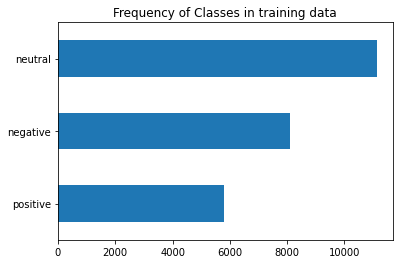

In [9]:
# Displaying the frequency of classes in the training data
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in training data")
plt.show()

In [10]:
valid_df = dataset["valid"][:]
valid_df["label_name"] = valid_df["label"].apply(label_int2str)
test_df = dataset["test"][:]
test_df["label_name"] = test_df["label"].apply(label_int2str)

print(train_df.groupby("label_name").count())
print(valid_df.groupby("label_name").count())
print(test_df.groupby("label_name").count())

            label   text
label_name              
negative     8108   8108
neutral     11128  11128
positive     5788   5788
            label  text
label_name             
negative      915   915
neutral      1238  1238
positive      628   628
            label  text
label_name             
negative      504   504
neutral       384   384
positive      413   413


In [11]:
# Resetting the dataset format
dataset.reset_format()

6. Tokenization

In [12]:
# Initializing the tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [13]:
# Defining tokenization function
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [14]:
# Applying the tokenize function across all the datasets (train/validation/test)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

7. Training a classifier (using fine tuning)

In [15]:
# Defining the performance metrics that will be used to evaluate our model's performance during fine-tuning
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  prec = precision_score(labels, preds, average="weighted")
  rec = recall_score(labels, preds, average="weighted")
  return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1}

In [16]:
# Defining the hyperparameters for the training run and the model
# If new training_args and model are not defined before a training is started the trainer continues training the model that is already trained


batch_size = 64
logging_steps = len(dataset_encoded["train"])
base_output_dir = "/content/drive/MyDrive/2022/College/COMP6321/saved_models/"
model_output_dir = base_output_dir + model_checkpoint
training_args = TrainingArguments(output_dir=model_output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  logging_strategy="epoch",
                                  disable_tqdm=False,
                                  log_level="error")

model_checkpoint = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3
model4_bert = (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
class_samples = [9023, 12366, 6416]
class_weights = [1 - (x / sum(class_samples)) for x in class_samples]
class_weights = torch.FloatTensor(class_weights).to(device)

In [18]:
class W22M4Trainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [19]:
# Training the model
trainer = W22M4Trainer(model=model4_bert, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["valid"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


RuntimeError: ignored

8. Calculating confusion matrix for validation data

In [ ]:
# Normalized confusion matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

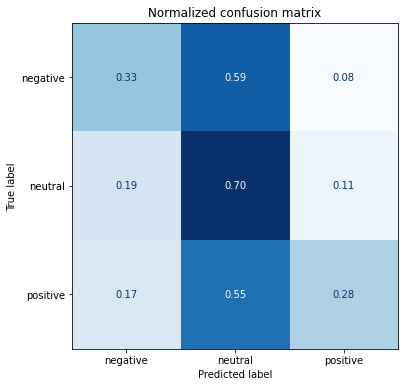

In [ ]:
# More detailed look at the training metrics by calculating the confusion matrix

y_valid = np.array(dataset_encoded["valid"]["label"])
labels = dataset["train"].features["label"].names

validation_predictions_all = trainer.predict(dataset_encoded["valid"])
y_preds_validation = np.argmax(validation_predictions_all.predictions, axis=1)
plot_confusion_matrix(y_preds_validation, y_valid, labels)

In [ ]:
from sklearn.metrics import classification_report

model4_bert_report_v = classification_report(y_valid, y_preds_validation, target_names=labels)
print(model4_bert_report_v)

              precision    recall  f1-score   support

    negative       0.47      0.33      0.38       909
     neutral       0.49      0.70      0.57      1217
    positive       0.46      0.28      0.35       655

    accuracy                           0.48      2781
   macro avg       0.47      0.44      0.44      2781
weighted avg       0.48      0.48      0.46      2781



12. Save model

In [ ]:
tokenizer.save_pretrained(model_output_dir)
model4_bert.save_pretrained(model_output_dir)

13. Load model and calculate confusion matrix for test data

In [ ]:
# Load model
loaded_m4 = (AutoModelForSequenceClassification.from_pretrained(model_output_dir, num_labels=num_labels).to(device))
trainer = Trainer(model=loaded_m4)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1301
  Batch size = 8


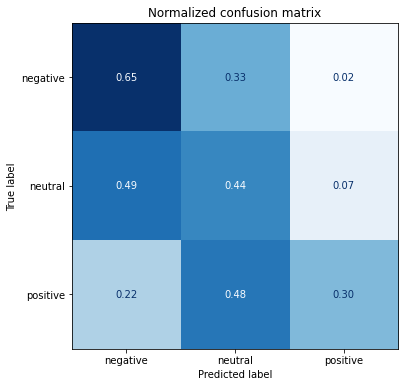

In [ ]:
# More detailed look at the training metrics by calculating the confusion matrix

y_test = np.array(dataset_encoded["test"]["label"])

test_predictions_all = trainer.predict(dataset_encoded["test"])
y_preds_test = np.argmax(test_predictions_all.predictions, axis=1)
plot_confusion_matrix(y_preds_test, y_test, labels)

In [ ]:
model4_bert_report_t = classification_report(y_test, y_preds_test, target_names=labels, output_dict=True)
print(model4_bert_report_t)

{'negative': {'precision': 0.588, 'recall': 0.5833333333333334, 'f1-score': 0.5856573705179283, 'support': 504}, 'neutral': {'precision': 0.30652503793626706, 'recall': 0.5260416666666666, 'f1-score': 0.3873441994247363, 'support': 384}, 'positive': {'precision': 0.8028169014084507, 'recall': 0.27602905569007263, 'f1-score': 0.4108108108108108, 'support': 413}, 'accuracy': 0.46887009992313605, 'macro avg': {'precision': 0.5657806464482392, 'recall': 0.46180135189669086, 'f1-score': 0.4612707935844918, 'support': 1301}, 'weighted avg': {'precision': 0.5731137546880989, 'recall': 0.46887009992313605, 'f1-score': 0.47161902550730167, 'support': 1301}}
